In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import torch.nn.init as init
from torch.autograd import Variable
from dataLoader import loadData
from tensorflow import keras

In [2]:
# !curl -O http://files.grouplens.org/datasets/movielens/ml-1m.zip

In [3]:
# !curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [4]:
# import zipfile
# with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')
    
# # !cd ml-1m/

In [5]:
# import zipfile
# with zipfile.ZipFile('ml-100k.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')
    
# # !cd ml-1m/

In [6]:
seed = 47
np.random.seed(seed)

We will use the following blogpost's independent code to benchmark our experiments https://blog.insightdatascience.com/explicit-matrix-factorization-als-sgd-and-all-that-jazz-b00e4d9b21ea

# Independent MF code

In [7]:
names = ['user_id', 'item_id', 'rating']
df = pd.read_csv('./ml-1m/ratings.dat', sep='::', usecols = [0, 1, 2], names=names)
df.head()

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,user_id,item_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [8]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
n_users, n_items

(6040, 3706)

In [13]:
n_users = df.user_id.unique().max()
n_items = df.item_id.unique().max()
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
#     print(row)
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [14]:
def get_sparsity(mat):
    sparsity = float(len(mat.nonzero()[0]))
    sparsity /= (mat.shape[0] * mat.shape[1])
    sparsity *= 100
    return sparsity

In [15]:
get_sparsity(ratings)

4.190220560634904

In [16]:
def train_test_split(ratings):
    np.random.seed(seed)
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [17]:
train_1m, test_1m = train_test_split(ratings)

In [18]:
train_1m

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [19]:
test_1m

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
get_sparsity(train_1m), get_sparsity(test_1m)

(3.93718412338794, 0.25303643724696356)

In [21]:
# movielens-100k dataset
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('./ml-100k/u.data', sep='\t', names=names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [22]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [23]:
train_100k, test_100k = train_test_split(ratings)

In [24]:
get_sparsity(train_100k), get_sparsity(test_100k)

(5.710139043178159, 0.5945303210463734)

In [25]:
train_100k.shape, train_1m.shape

((943, 1682), (6040, 3952))

In [39]:
from numpy.linalg import solve

class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        np.random.seed(seed)
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        np.random.seed(seed)
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors,
                                          size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        np.random.seed(seed)
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print ('\tcurrent iteration: {}'.format(ctr))
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        np.random.seed(seed)
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate * \
                                (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * \
                                (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (e * self.item_vecs[i, :] - \
                                     self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - \
                                     self.item_fact_reg * self.item_vecs[i,:])
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        np.random.seed(seed)
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print ('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print ('Train mse: ' + str(self.train_mse[-1]))
                print ('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [40]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [49]:
iter_array = [1, 2, 5, 10, 15, 20, 30, 40, 50, 70, 90, 120, 150, 180, 220]

In [50]:
mf_als_100k = ExplicitMF(train_100k, n_factors=10, learning='als',
                    user_fact_reg=0.1, item_fact_reg=0.1, verbose=True)
mf_als_100k.calculate_learning_curve(iter_array, test_100k)

Iteration: 1
Train mse: 7.8411868244782985
Test mse: 10.956557787912471
Iteration: 2
Train mse: 5.731156257503645
Test mse: 8.66466855942882
Iteration: 5
Train mse: 5.41223275733234
Test mse: 8.225124472876551
Iteration: 10
Train mse: 5.394598612851955
Test mse: 8.198143635604692
Iteration: 15
Train mse: 5.394247417232219
Test mse: 8.195833868503952
Iteration: 20
Train mse: 5.394379239268623
Test mse: 8.195289830055355
Iteration: 30
	current iteration: 10
Train mse: 5.3945005206942245
Test mse: 8.195034177862206
Iteration: 40
	current iteration: 10
Train mse: 5.3944932331994435
Test mse: 8.194950846116674
Iteration: 50
	current iteration: 10
Train mse: 5.394455951420811
Test mse: 8.194896519679713
Iteration: 70
	current iteration: 10
	current iteration: 20
Train mse: 5.394371825530081
Test mse: 8.194806909146267
Iteration: 90
	current iteration: 10
	current iteration: 20
Train mse: 5.394292444373804
Test mse: 8.194726383144022
Iteration: 120
	current iteration: 10
	current iteration: 2

In [60]:
def plot_curve(values, title_name, xlabel, ylabel, iterations=iter_array, plot_type="plot"):
    if plot_type=="plot":
        plt.plot(iterations, values)
    elif plot_type=="scatter":
        plt.scatter(iterations, values)
    else:
        return
    plt.title(title_name)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

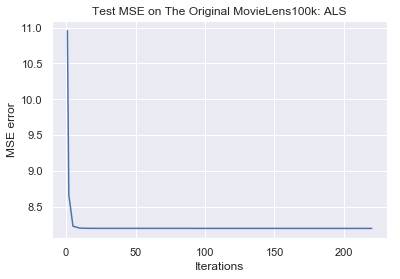

In [64]:
plot_curve(values=mf_als_100k.test_mse, title_name="Test MSE on The Original MovieLens100k: ALS", xlabel="Iterations", ylabel="MSE error")

In [69]:
min(mf_als_100k.test_mse)

8.194329080408963

In [62]:
# We are using the best fine tuned hyperparameters of the blog post for evaluation
mf_sgd_100k = ExplicitMF(train_100k, 40, learning='sgd', verbose=True)
mf_sgd_100k.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 1.142903905755556
Test mse: 1.1796423589839398
Iteration: 2
Train mse: 1.0731571399242776
Test mse: 1.1283642555477047
Iteration: 5
Train mse: 0.9768279872277285
Test mse: 1.0498298549996896
Iteration: 10
Train mse: 0.9191761690006633
Test mse: 0.9986910865034175
Iteration: 15
Train mse: 0.8931844079487902
Test mse: 0.9750973624132867
Iteration: 20
Train mse: 0.8776784607465106
Test mse: 0.9613232749048447
Iteration: 30
	current iteration: 10
Train mse: 0.8592955446513819
Test mse: 0.946187289250373
Iteration: 40
	current iteration: 10
Train mse: 0.8480564814313558
Test mse: 0.9385166159690298
Iteration: 50
	current iteration: 10
Train mse: 0.8393903153961552
Test mse: 0.9341865831260542
Iteration: 70
	current iteration: 10
	current iteration: 20
Train mse: 0.8202469350671223
Test mse: 0.9290442210331938
Iteration: 90
	current iteration: 10
	current iteration: 20
Train mse: 0.7827904694456294
Test mse: 0.9220315219430705
Iteration: 120
	current iteration: 10
	cu

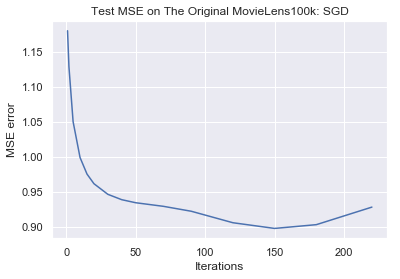

In [66]:
plot_curve(values=mf_sgd_100k.test_mse, title_name="Test MSE on The Original MovieLens100k: SGD", xlabel="Iterations", ylabel="MSE error")

In [70]:
min(mf_sgd_100k.test_mse)

0.8975222763790961

# Our Proposed GAN

In [71]:
if torch.cuda.is_available() == True:
    device = "cuda"
else:
    device = "cpu"

In [72]:
zero_mask = (train_100k == 0)
positive_feedback = (train_100k > 3)
negative_feedback = ((train_100k < 4) * (1 - zero_mask))

In [73]:
positive_feedback.sum(), negative_feedback.sum()

(49901, 40669)

In [74]:
assert (positive_feedback + negative_feedback != zero_mask).all()
assert (positive_feedback + negative_feedback == 1 - zero_mask).all()

In [75]:
get_sparsity(zero_mask), get_sparsity(positive_feedback), get_sparsity(negative_feedback)

(94.28986095682184, 3.146093059441684, 2.5640459837364746)

In [113]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, mat, batch_size=128):
        '''
        mat is a binary matrix (e.g. positive feedback, or negative feedback)
        '''
        self.batch_size=batch_size
        self.mat=mat
        self.p=[0.1, 0.5]

    def __len__(self):
        return int(np.floor(self.mat.shape[0] / self.batch_size))
    
    def gen_item_GAN(self):
        indexes = np.random.randint(self.mat.shape[0], size=self.batch_size)

        mask = (np.random.rand(self.batch_size, self.mat.shape[1]) > np.random.uniform(self.p[0], self.p[1]))
        
        y = self.mat[indexes]
        X = self.mat[indexes]*mask # corrupting
        
        return X, y, indexes
        
    def __getitem__(self, index):
        
        indexes = np.random.randint(self.mat.shape[0], size=self.batch_size)

        mask = (np.random.rand(self.batch_size, self.mat.shape[1]) > self.p)
        
        y = self.mat[indexes]
        X = self.mat[indexes]*mask # corrupting
        
        return X, y

In [114]:
generator_negative = DataGenerator(negative_feedback)

In [115]:
x, y, _ = generator_negative.gen_item_GAN()

In [116]:
get_sparsity(x), get_sparsity(y)

(2.3576843043995246, 3.046503418549346)

In [117]:
class NetD(torch.nn.Module):
    def __init__(self, feat_size):
        super(NetD, self).__init__()
        self.feat_size = feat_size
#         self.use_cuda = True
#         self.feat_size = feat_size
        # top
#         print(self.feat_size*2)
        self.t1 = torch.nn.Linear(self.feat_size, 1024)
        # bottom
        self.b1 = torch.nn.Linear(self.feat_size, 1024)
        # combined
        self.fc = torch.nn.Linear(2 * 1024, self.feat_size)
    def forward(self, xr, xf):
        # get filt
        
        filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
        # random swap
        idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
        idrx = idr.float().unsqueeze(1).expand_as(xr)
#         if self.use_cuda: 
        idrx = idrx.cuda()
        idrx = Variable(idrx)
        xt = xr * idrx + xf * (1 - idrx)
        xb = xr * (1 - idrx) + xf * idrx
        # top : real
        xt = F.relu(self.t1(xt))
        # bottom : fake
        xb = F.relu(self.b1(xb))
        # combined
        x = torch.cat((xt, xb), 1)
        x = torch.tanh(self.fc(x))
        # apply filter, aggregate
        x = filt * x
        x = x.mean(dim = 1).squeeze()
        # use sign, because of swapping
        sgn = idr * 2 - 1
        sgn = sgn.cuda()
        sgn = Variable(sgn.float())
        x = sgn * x
        return x


class NetG(nn.Module):
    
    def __init__(self, feat_size):

        super(NetG, self).__init__()
        self.feat_size = feat_size
        self.netGen = torch.nn.Sequential( 
                                torch.nn.Linear(nz + self.feat_size, 1024), 
#                                 torch.nn.BatchNorm1d(1024),
#                                 torch.nn.ReLU(), 
# #                                 nn.Dropout(0.5),
#                                 torch.nn.Linear(2048, 2048),
                                torch.nn.ReLU(), 
#                                 torch.nn.BatchNorm1d(512),
#                                 nn.Dropout(0.6),
                                torch.nn.Linear(1024, self.feat_size), 
                                torch.nn.Sigmoid()
#                                 torch.nn.BatchNorm1d(features_length),
#                                 nn.Dropout(0.7),
#                                 torch.nn.Sigmoid()
                                )

        
    def forward(self, e_mask, x):
        x = self.netGen(x)
#         print(x.shape, )
        x = x * e_mask
        return x
#         return F.dropout(x, 0.7)
#         return 5 * self.netGen(x)
#         return torch.sigmoid(x) 
#         return x*5 # to get values in range [0,5]

In [118]:
gen_losses = []
disc_losses = []

def train_GAN(netD, netG, negative, tr, steps_per_epoch = 200, epochs = 10):
    d_iter = 10
    g_iter = 1
    gen_iterations = 0
    for epoch in range(epochs):
        for c in range(steps_per_epoch):
            i = 0
            for p in netD.parameters(): # reset requires_grad
                p.requires_grad = True # they are set to False below in netG update
            j = 0
            while j < d_iter:
                j += 1
                i += 1
                if negative:
                    condition, X, idxs = generator_negative.gen_item_GAN()
                    
                X = torch.from_numpy(X).float().cuda()
                condition = torch.from_numpy(condition).float().cuda() 
                real = Variable(X)

                # generate fake data
                noise = torch.randn(batch_size, nz)
#                     if cuda: 
                noise = noise.cuda()

                with torch.no_grad():
                    noisev = Variable(noise) 
                concated = torch.cat((noisev, condition), 1)

                e_mask = torch.Tensor(tr[idxs]>0).cuda()
                fake = Variable(netG(e_mask, concated).data)

                netD.zero_grad()
                out = netD(real, fake)
                outputD = torch.mean(out) + lamba * out.norm()
                stdD = torch.std(out)
                outputD.backward(mone)
                optimizerD.step()

            j = 0
            while j < g_iter:
                j += 1
                for p in netD.parameters():
                    p.requires_grad = False # to avoid computation
                netG.zero_grad()
                
                i += 1

                if negative:
                    condition, X, idxs = generator_negative.gen_item_GAN()

                X = torch.from_numpy(X).float().cuda()
                condition = torch.from_numpy(condition).float().cuda() 
                real = Variable(X)

                noise = torch.randn(batch_size, nz)
                noise = noise.cuda()
                noisev = Variable(noise)
                concated_ = torch.cat((noisev, condition), 1)
                e_mask_ = torch.Tensor(tr[idxs]>0).cuda()

                fake = netG(e_mask_, concated_)
                out = netD(real, fake)
                outputG = torch.mean(out) + lamba * out.norm()
                stdG = torch.std(out)
                outputG.backward(one)
                optimizerG.step()
                gen_iterations += 1
                gen_losses.append(outputG.item())
                disc_losses.append(outputD.item())
                print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f '% (epoch, epochs, i, 100, gen_iterations, outputD.item(), outputG.item()))
    return gen_losses, disc_losses

In [119]:
lrD = 5e-4
lrG = 5e-4
batch_size = 128
cuda = True
epochs = 12
nz = 6
lamba = 1e-3

In [120]:
# networks
netD_neg = NetD(train_100k.shape[1]).cuda()
netG_neg = NetG(train_100k.shape[1]).cuda()
print(netD_neg)
print(netG_neg)
optimizerG = optim.Adam(netG_neg.parameters(), lr=lrG, weight_decay=1e-4)
optimizerD = optim.Adam(netD_neg.parameters(), lr=lrD, weight_decay=1e-4)
one = torch.FloatTensor([1]).cuda()
mone = (-1 * one).cuda()

NetD(
  (t1): Linear(in_features=1682, out_features=1024, bias=True)
  (b1): Linear(in_features=1682, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=1682, bias=True)
)
NetG(
  (netGen): Sequential(
    (0): Linear(in_features=1688, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1682, bias=True)
    (3): Sigmoid()
  )
)


In [121]:
netD_neg.train()
netG_neg.train()
# gen_losses, disc_losses = train_GAN(netD_neg, netG_neg, negative=True)
# loss values doesn't say much about the quality
train_GAN(netD_neg, netG_neg, tr=train_100k, epochs=10, negative=True)

[0/10][11/100][1] Loss_D: 0.000670 Loss_G: 0.000474 
[0/10][11/100][2] Loss_D: 0.002240 Loss_G: 0.001618 
[0/10][11/100][3] Loss_D: 0.005193 Loss_G: 0.004800 
[0/10][11/100][4] Loss_D: 0.009984 Loss_G: 0.013757 
[0/10][11/100][5] Loss_D: 0.014459 Loss_G: 0.014902 
[0/10][11/100][6] Loss_D: 0.016748 Loss_G: 0.014249 
[0/10][11/100][7] Loss_D: 0.016947 Loss_G: 0.018742 
[0/10][11/100][8] Loss_D: 0.014817 Loss_G: 0.015056 
[0/10][11/100][9] Loss_D: 0.014909 Loss_G: 0.012258 
[0/10][11/100][10] Loss_D: 0.011858 Loss_G: 0.013391 
[0/10][11/100][11] Loss_D: 0.013614 Loss_G: 0.014280 
[0/10][11/100][12] Loss_D: 0.011200 Loss_G: 0.014024 
[0/10][11/100][13] Loss_D: 0.012275 Loss_G: 0.013856 
[0/10][11/100][14] Loss_D: 0.014394 Loss_G: 0.012272 
[0/10][11/100][15] Loss_D: 0.010137 Loss_G: 0.007623 
[0/10][11/100][16] Loss_D: 0.010667 Loss_G: 0.013667 
[0/10][11/100][17] Loss_D: 0.009735 Loss_G: 0.007181 
[0/10][11/100][18] Loss_D: 0.007899 Loss_G: 0.008333 
[0/10][11/100][19] Loss_D: 0.007862 L

[0/10][11/100][153] Loss_D: 0.003649 Loss_G: 0.003998 
[0/10][11/100][154] Loss_D: 0.001075 Loss_G: 0.005746 
[0/10][11/100][155] Loss_D: 0.002678 Loss_G: 0.004061 
[0/10][11/100][156] Loss_D: 0.004598 Loss_G: 0.002374 
[0/10][11/100][157] Loss_D: 0.004121 Loss_G: 0.001013 
[0/10][11/100][158] Loss_D: 0.002826 Loss_G: 0.003581 
[0/10][11/100][159] Loss_D: 0.002696 Loss_G: 0.004599 
[0/10][11/100][160] Loss_D: 0.002070 Loss_G: 0.002771 
[0/10][11/100][161] Loss_D: 0.003766 Loss_G: 0.004962 
[0/10][11/100][162] Loss_D: 0.003449 Loss_G: 0.002939 
[0/10][11/100][163] Loss_D: 0.004212 Loss_G: 0.003112 
[0/10][11/100][164] Loss_D: 0.001063 Loss_G: 0.004859 
[0/10][11/100][165] Loss_D: 0.003799 Loss_G: 0.004925 
[0/10][11/100][166] Loss_D: 0.002106 Loss_G: 0.003633 
[0/10][11/100][167] Loss_D: 0.003290 Loss_G: 0.001934 
[0/10][11/100][168] Loss_D: 0.003833 Loss_G: 0.002940 
[0/10][11/100][169] Loss_D: 0.004704 Loss_G: 0.002759 
[0/10][11/100][170] Loss_D: 0.000948 Loss_G: 0.001920 
[0/10][11/

[1/10][11/100][302] Loss_D: 0.001638 Loss_G: 0.003299 
[1/10][11/100][303] Loss_D: 0.003891 Loss_G: 0.003591 
[1/10][11/100][304] Loss_D: 0.001549 Loss_G: 0.003033 
[1/10][11/100][305] Loss_D: 0.005549 Loss_G: 0.002959 
[1/10][11/100][306] Loss_D: 0.002181 Loss_G: 0.002626 
[1/10][11/100][307] Loss_D: 0.003455 Loss_G: 0.001826 
[1/10][11/100][308] Loss_D: 0.004968 Loss_G: 0.002907 
[1/10][11/100][309] Loss_D: 0.002962 Loss_G: 0.001476 
[1/10][11/100][310] Loss_D: 0.002350 Loss_G: 0.003297 
[1/10][11/100][311] Loss_D: 0.002775 Loss_G: 0.004724 
[1/10][11/100][312] Loss_D: 0.002800 Loss_G: 0.002622 
[1/10][11/100][313] Loss_D: 0.003316 Loss_G: 0.003940 
[1/10][11/100][314] Loss_D: 0.004650 Loss_G: 0.004594 
[1/10][11/100][315] Loss_D: 0.005866 Loss_G: 0.003045 
[1/10][11/100][316] Loss_D: 0.006058 Loss_G: 0.003664 
[1/10][11/100][317] Loss_D: 0.004708 Loss_G: 0.004712 
[1/10][11/100][318] Loss_D: 0.004541 Loss_G: 0.004470 
[1/10][11/100][319] Loss_D: 0.004869 Loss_G: 0.005201 
[1/10][11/

[2/10][11/100][451] Loss_D: 0.006262 Loss_G: 0.008402 
[2/10][11/100][452] Loss_D: 0.009356 Loss_G: 0.007833 
[2/10][11/100][453] Loss_D: 0.007068 Loss_G: 0.007513 
[2/10][11/100][454] Loss_D: 0.005632 Loss_G: 0.008382 
[2/10][11/100][455] Loss_D: 0.005476 Loss_G: 0.005642 
[2/10][11/100][456] Loss_D: 0.006222 Loss_G: 0.003286 
[2/10][11/100][457] Loss_D: 0.005005 Loss_G: 0.003284 
[2/10][11/100][458] Loss_D: 0.003742 Loss_G: 0.002978 
[2/10][11/100][459] Loss_D: 0.000510 Loss_G: 0.001151 
[2/10][11/100][460] Loss_D: 0.003724 Loss_G: 0.003656 
[2/10][11/100][461] Loss_D: 0.003211 Loss_G: 0.001474 
[2/10][11/100][462] Loss_D: 0.003801 Loss_G: 0.002441 
[2/10][11/100][463] Loss_D: 0.001523 Loss_G: 0.004014 
[2/10][11/100][464] Loss_D: 0.001593 Loss_G: 0.002882 
[2/10][11/100][465] Loss_D: 0.003571 Loss_G: 0.003674 
[2/10][11/100][466] Loss_D: 0.004011 Loss_G: 0.001542 
[2/10][11/100][467] Loss_D: 0.003060 Loss_G: -0.000136 
[2/10][11/100][468] Loss_D: 0.000764 Loss_G: 0.000453 
[2/10][11

[3/10][11/100][601] Loss_D: 0.003392 Loss_G: 0.005666 
[3/10][11/100][602] Loss_D: 0.002050 Loss_G: 0.003590 
[3/10][11/100][603] Loss_D: 0.007132 Loss_G: 0.002632 
[3/10][11/100][604] Loss_D: 0.004446 Loss_G: 0.002699 
[3/10][11/100][605] Loss_D: 0.003883 Loss_G: 0.002575 
[3/10][11/100][606] Loss_D: 0.002283 Loss_G: 0.003850 
[3/10][11/100][607] Loss_D: 0.003376 Loss_G: 0.004036 
[3/10][11/100][608] Loss_D: 0.001888 Loss_G: 0.002942 
[3/10][11/100][609] Loss_D: 0.002446 Loss_G: 0.003218 
[3/10][11/100][610] Loss_D: 0.002217 Loss_G: 0.003239 
[3/10][11/100][611] Loss_D: 0.002208 Loss_G: 0.002305 
[3/10][11/100][612] Loss_D: 0.002093 Loss_G: 0.002799 
[3/10][11/100][613] Loss_D: 0.002558 Loss_G: 0.002271 
[3/10][11/100][614] Loss_D: 0.004217 Loss_G: 0.001379 
[3/10][11/100][615] Loss_D: 0.002084 Loss_G: 0.001320 
[3/10][11/100][616] Loss_D: 0.002451 Loss_G: 0.001555 
[3/10][11/100][617] Loss_D: 0.004600 Loss_G: 0.003200 
[3/10][11/100][618] Loss_D: 0.002305 Loss_G: 0.001703 
[3/10][11/

[3/10][11/100][751] Loss_D: 0.001758 Loss_G: 0.002164 
[3/10][11/100][752] Loss_D: 0.002948 Loss_G: 0.001042 
[3/10][11/100][753] Loss_D: 0.005248 Loss_G: 0.003644 
[3/10][11/100][754] Loss_D: 0.003893 Loss_G: 0.000826 
[3/10][11/100][755] Loss_D: 0.001501 Loss_G: 0.003178 
[3/10][11/100][756] Loss_D: 0.001799 Loss_G: 0.001159 
[3/10][11/100][757] Loss_D: 0.002410 Loss_G: 0.002339 
[3/10][11/100][758] Loss_D: 0.003079 Loss_G: 0.003249 
[3/10][11/100][759] Loss_D: 0.002660 Loss_G: 0.003763 
[3/10][11/100][760] Loss_D: 0.002218 Loss_G: 0.002651 
[3/10][11/100][761] Loss_D: 0.001615 Loss_G: 0.001027 
[3/10][11/100][762] Loss_D: 0.003546 Loss_G: 0.003424 
[3/10][11/100][763] Loss_D: 0.003800 Loss_G: 0.002242 
[3/10][11/100][764] Loss_D: 0.002510 Loss_G: 0.003418 
[3/10][11/100][765] Loss_D: 0.004781 Loss_G: 0.004191 
[3/10][11/100][766] Loss_D: 0.005929 Loss_G: 0.002337 
[3/10][11/100][767] Loss_D: 0.002751 Loss_G: 0.001757 
[3/10][11/100][768] Loss_D: 0.003126 Loss_G: 0.004287 
[3/10][11/

[4/10][11/100][900] Loss_D: 0.004460 Loss_G: 0.003773 
[4/10][11/100][901] Loss_D: 0.002809 Loss_G: 0.004179 
[4/10][11/100][902] Loss_D: 0.004028 Loss_G: 0.002033 
[4/10][11/100][903] Loss_D: 0.004022 Loss_G: 0.002753 
[4/10][11/100][904] Loss_D: 0.005246 Loss_G: 0.005065 
[4/10][11/100][905] Loss_D: 0.003397 Loss_G: 0.004988 
[4/10][11/100][906] Loss_D: 0.005569 Loss_G: 0.004194 
[4/10][11/100][907] Loss_D: 0.004913 Loss_G: 0.004203 
[4/10][11/100][908] Loss_D: 0.003993 Loss_G: 0.003118 
[4/10][11/100][909] Loss_D: 0.003858 Loss_G: 0.002556 
[4/10][11/100][910] Loss_D: 0.004170 Loss_G: 0.002643 
[4/10][11/100][911] Loss_D: 0.004012 Loss_G: 0.003337 
[4/10][11/100][912] Loss_D: 0.004323 Loss_G: 0.004138 
[4/10][11/100][913] Loss_D: 0.002781 Loss_G: 0.003578 
[4/10][11/100][914] Loss_D: 0.002909 Loss_G: 0.002763 
[4/10][11/100][915] Loss_D: 0.003135 Loss_G: 0.002460 
[4/10][11/100][916] Loss_D: 0.002569 Loss_G: 0.002031 
[4/10][11/100][917] Loss_D: 0.002787 Loss_G: 0.004899 
[4/10][11/

[5/10][11/100][1049] Loss_D: 0.003142 Loss_G: 0.003382 
[5/10][11/100][1050] Loss_D: 0.002456 Loss_G: 0.004435 
[5/10][11/100][1051] Loss_D: 0.003717 Loss_G: 0.002629 
[5/10][11/100][1052] Loss_D: 0.004067 Loss_G: 0.004054 
[5/10][11/100][1053] Loss_D: 0.002396 Loss_G: 0.002191 
[5/10][11/100][1054] Loss_D: 0.003370 Loss_G: 0.002938 
[5/10][11/100][1055] Loss_D: 0.001255 Loss_G: 0.001972 
[5/10][11/100][1056] Loss_D: 0.002856 Loss_G: 0.002302 
[5/10][11/100][1057] Loss_D: 0.004546 Loss_G: 0.001592 
[5/10][11/100][1058] Loss_D: 0.003239 Loss_G: 0.002578 
[5/10][11/100][1059] Loss_D: 0.003301 Loss_G: 0.002423 
[5/10][11/100][1060] Loss_D: 0.003287 Loss_G: 0.003648 
[5/10][11/100][1061] Loss_D: 0.002802 Loss_G: 0.002515 
[5/10][11/100][1062] Loss_D: 0.002349 Loss_G: 0.002209 
[5/10][11/100][1063] Loss_D: 0.003264 Loss_G: 0.004121 
[5/10][11/100][1064] Loss_D: 0.002749 Loss_G: 0.003087 
[5/10][11/100][1065] Loss_D: 0.003922 Loss_G: 0.002613 
[5/10][11/100][1066] Loss_D: 0.004144 Loss_G: 0.

[5/10][11/100][1197] Loss_D: 0.002361 Loss_G: 0.002276 
[5/10][11/100][1198] Loss_D: 0.001459 Loss_G: 0.003124 
[5/10][11/100][1199] Loss_D: 0.001553 Loss_G: 0.001437 
[5/10][11/100][1200] Loss_D: 0.002456 Loss_G: 0.002159 
[6/10][11/100][1201] Loss_D: 0.001804 Loss_G: 0.004178 
[6/10][11/100][1202] Loss_D: 0.001002 Loss_G: 0.002154 
[6/10][11/100][1203] Loss_D: 0.002268 Loss_G: 0.001678 
[6/10][11/100][1204] Loss_D: 0.002412 Loss_G: 0.002745 
[6/10][11/100][1205] Loss_D: 0.001807 Loss_G: 0.002279 
[6/10][11/100][1206] Loss_D: 0.003936 Loss_G: 0.003851 
[6/10][11/100][1207] Loss_D: 0.001866 Loss_G: 0.003527 
[6/10][11/100][1208] Loss_D: 0.002065 Loss_G: 0.002097 
[6/10][11/100][1209] Loss_D: 0.002103 Loss_G: 0.003454 
[6/10][11/100][1210] Loss_D: 0.004667 Loss_G: 0.002647 
[6/10][11/100][1211] Loss_D: 0.003616 Loss_G: 0.000210 
[6/10][11/100][1212] Loss_D: 0.003135 Loss_G: 0.002896 
[6/10][11/100][1213] Loss_D: 0.003631 Loss_G: 0.001041 
[6/10][11/100][1214] Loss_D: 0.003435 Loss_G: 0.

[6/10][11/100][1345] Loss_D: 0.003949 Loss_G: 0.006021 
[6/10][11/100][1346] Loss_D: 0.002482 Loss_G: 0.001499 
[6/10][11/100][1347] Loss_D: 0.004463 Loss_G: 0.003217 
[6/10][11/100][1348] Loss_D: 0.003839 Loss_G: 0.003858 
[6/10][11/100][1349] Loss_D: 0.002723 Loss_G: 0.001655 
[6/10][11/100][1350] Loss_D: 0.001793 Loss_G: 0.002810 
[6/10][11/100][1351] Loss_D: 0.002661 Loss_G: 0.003229 
[6/10][11/100][1352] Loss_D: 0.005020 Loss_G: 0.003773 
[6/10][11/100][1353] Loss_D: 0.002604 Loss_G: 0.003043 
[6/10][11/100][1354] Loss_D: 0.002127 Loss_G: 0.002853 
[6/10][11/100][1355] Loss_D: 0.002561 Loss_G: 0.003193 
[6/10][11/100][1356] Loss_D: 0.003200 Loss_G: 0.002835 
[6/10][11/100][1357] Loss_D: 0.003588 Loss_G: 0.003159 
[6/10][11/100][1358] Loss_D: 0.003675 Loss_G: 0.003318 
[6/10][11/100][1359] Loss_D: 0.003179 Loss_G: 0.002656 
[6/10][11/100][1360] Loss_D: 0.003554 Loss_G: 0.003647 
[6/10][11/100][1361] Loss_D: 0.004291 Loss_G: 0.002846 
[6/10][11/100][1362] Loss_D: 0.004875 Loss_G: 0.

[7/10][11/100][1493] Loss_D: 0.003501 Loss_G: 0.002723 
[7/10][11/100][1494] Loss_D: 0.002484 Loss_G: 0.003485 
[7/10][11/100][1495] Loss_D: 0.007173 Loss_G: 0.003188 
[7/10][11/100][1496] Loss_D: 0.004232 Loss_G: 0.004528 
[7/10][11/100][1497] Loss_D: 0.002394 Loss_G: 0.004107 
[7/10][11/100][1498] Loss_D: 0.003543 Loss_G: 0.003552 
[7/10][11/100][1499] Loss_D: 0.004231 Loss_G: 0.004644 
[7/10][11/100][1500] Loss_D: 0.004750 Loss_G: 0.005289 
[7/10][11/100][1501] Loss_D: 0.002439 Loss_G: 0.003268 
[7/10][11/100][1502] Loss_D: 0.003771 Loss_G: 0.003329 
[7/10][11/100][1503] Loss_D: 0.003521 Loss_G: 0.004026 
[7/10][11/100][1504] Loss_D: 0.002448 Loss_G: 0.003762 
[7/10][11/100][1505] Loss_D: 0.003297 Loss_G: 0.003416 
[7/10][11/100][1506] Loss_D: 0.003041 Loss_G: 0.003630 
[7/10][11/100][1507] Loss_D: 0.003670 Loss_G: 0.004146 
[7/10][11/100][1508] Loss_D: 0.003832 Loss_G: 0.002388 
[7/10][11/100][1509] Loss_D: 0.002901 Loss_G: 0.004423 
[7/10][11/100][1510] Loss_D: 0.002540 Loss_G: 0.

[8/10][11/100][1641] Loss_D: 0.003353 Loss_G: 0.003886 
[8/10][11/100][1642] Loss_D: 0.002414 Loss_G: 0.003210 
[8/10][11/100][1643] Loss_D: 0.004078 Loss_G: 0.003783 
[8/10][11/100][1644] Loss_D: 0.003572 Loss_G: 0.003432 
[8/10][11/100][1645] Loss_D: 0.002063 Loss_G: 0.004135 
[8/10][11/100][1646] Loss_D: 0.003732 Loss_G: 0.002831 
[8/10][11/100][1647] Loss_D: 0.001468 Loss_G: 0.003292 
[8/10][11/100][1648] Loss_D: 0.003608 Loss_G: 0.005628 
[8/10][11/100][1649] Loss_D: 0.001808 Loss_G: 0.002292 
[8/10][11/100][1650] Loss_D: 0.002953 Loss_G: 0.003807 
[8/10][11/100][1651] Loss_D: 0.003002 Loss_G: 0.003505 
[8/10][11/100][1652] Loss_D: 0.002506 Loss_G: 0.002420 
[8/10][11/100][1653] Loss_D: 0.002902 Loss_G: 0.002283 
[8/10][11/100][1654] Loss_D: 0.002184 Loss_G: 0.003278 
[8/10][11/100][1655] Loss_D: 0.002039 Loss_G: 0.002555 
[8/10][11/100][1656] Loss_D: 0.002618 Loss_G: 0.002701 
[8/10][11/100][1657] Loss_D: 0.002611 Loss_G: 0.002489 
[8/10][11/100][1658] Loss_D: 0.003914 Loss_G: 0.

[8/10][11/100][1789] Loss_D: 0.003616 Loss_G: 0.006177 
[8/10][11/100][1790] Loss_D: 0.004469 Loss_G: 0.005069 
[8/10][11/100][1791] Loss_D: 0.003583 Loss_G: 0.006264 
[8/10][11/100][1792] Loss_D: 0.004103 Loss_G: 0.004654 
[8/10][11/100][1793] Loss_D: 0.005602 Loss_G: 0.005288 
[8/10][11/100][1794] Loss_D: 0.004371 Loss_G: 0.004072 
[8/10][11/100][1795] Loss_D: 0.005903 Loss_G: 0.005203 
[8/10][11/100][1796] Loss_D: 0.003821 Loss_G: 0.004724 
[8/10][11/100][1797] Loss_D: 0.004806 Loss_G: 0.002644 
[8/10][11/100][1798] Loss_D: 0.003360 Loss_G: 0.003007 
[8/10][11/100][1799] Loss_D: 0.003699 Loss_G: 0.004090 
[8/10][11/100][1800] Loss_D: 0.002966 Loss_G: 0.002590 
[9/10][11/100][1801] Loss_D: 0.002754 Loss_G: 0.002271 
[9/10][11/100][1802] Loss_D: 0.001497 Loss_G: 0.003142 
[9/10][11/100][1803] Loss_D: 0.002485 Loss_G: 0.003158 
[9/10][11/100][1804] Loss_D: 0.001450 Loss_G: 0.003145 
[9/10][11/100][1805] Loss_D: 0.002908 Loss_G: 0.002296 
[9/10][11/100][1806] Loss_D: 0.001730 Loss_G: 0.

[9/10][11/100][1937] Loss_D: 0.003295 Loss_G: 0.002633 
[9/10][11/100][1938] Loss_D: 0.001843 Loss_G: 0.002150 
[9/10][11/100][1939] Loss_D: 0.002738 Loss_G: 0.002553 
[9/10][11/100][1940] Loss_D: 0.003296 Loss_G: 0.003283 
[9/10][11/100][1941] Loss_D: 0.004710 Loss_G: 0.003439 
[9/10][11/100][1942] Loss_D: 0.005435 Loss_G: 0.004152 
[9/10][11/100][1943] Loss_D: 0.003987 Loss_G: 0.002874 
[9/10][11/100][1944] Loss_D: 0.002958 Loss_G: 0.003243 
[9/10][11/100][1945] Loss_D: 0.002789 Loss_G: 0.003881 
[9/10][11/100][1946] Loss_D: 0.007536 Loss_G: 0.003610 
[9/10][11/100][1947] Loss_D: 0.002741 Loss_G: 0.003355 
[9/10][11/100][1948] Loss_D: 0.003245 Loss_G: 0.004789 
[9/10][11/100][1949] Loss_D: 0.004415 Loss_G: 0.006126 
[9/10][11/100][1950] Loss_D: 0.004061 Loss_G: 0.002871 
[9/10][11/100][1951] Loss_D: 0.003049 Loss_G: 0.006204 
[9/10][11/100][1952] Loss_D: 0.006745 Loss_G: 0.005687 
[9/10][11/100][1953] Loss_D: 0.003776 Loss_G: 0.004855 
[9/10][11/100][1954] Loss_D: 0.003163 Loss_G: 0.

([0.00047373128472827375,
  0.0016182487597689033,
  0.004799982067197561,
  0.013757405802607536,
  0.014902498573064804,
  0.014248891733586788,
  0.018742462620139122,
  0.015055525116622448,
  0.01225843746215105,
  0.013391340151429176,
  0.01428008172661066,
  0.014023947529494762,
  0.013855948112905025,
  0.01227218471467495,
  0.007622892037034035,
  0.013667283579707146,
  0.007180624175816774,
  0.008332709781825542,
  0.006417845841497183,
  0.006468931678682566,
  0.0056929499842226505,
  0.002576603554189205,
  0.004144396632909775,
  0.0037370927166193724,
  0.0003084295312874019,
  0.003569179680198431,
  0.004917819052934647,
  0.006075013428926468,
  0.006944958586245775,
  0.006863292772322893,
  0.007946056313812733,
  0.005367444362491369,
  0.004620695952326059,
  0.0073073795065283775,
  0.007262731436640024,
  0.006989047862589359,
  0.004170836415141821,
  0.008425647392868996,
  0.002997151343151927,
  0.004834684077650309,
  0.004399136174470186,
  0.00908624

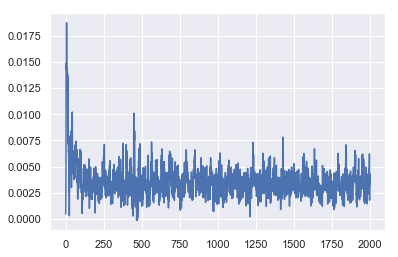

In [122]:
plt.plot(gen_losses)
plt.show()

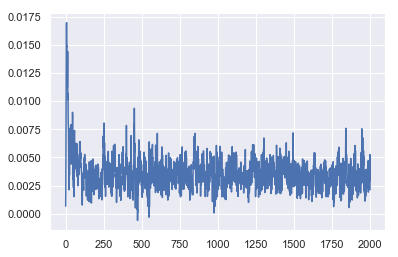

In [123]:
plt.plot(disc_losses)
plt.show()

In [124]:
# to test without train
netD_neg_test = NetD(train_100k.shape[1]).cuda()
netG_neg_test = NetG(train_100k.shape[1]).cuda()

netD_neg_test.eval()
netG_neg_test.eval()

NetG(
  (netGen): Sequential(
    (0): Linear(in_features=1688, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1682, bias=True)
    (3): Sigmoid()
  )
)

In [125]:
netD_neg.eval()
netG_neg.eval()

NetG(
  (netGen): Sequential(
    (0): Linear(in_features=1688, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1682, bias=True)
    (3): Sigmoid()
  )
)

In [126]:
# checking accuraccy
condition = torch.from_numpy(negative_feedback).float().cuda() 
noise = torch.randn(condition.shape[0], nz).cuda()
# e_mask = torch.Tensor(to_add_negative).cuda()
e_mask = torch.Tensor(train_100k > 0).cuda()

concated = torch.cat((noise, condition), 1)
fake_accur_check = netG_neg(e_mask, concated)

In [127]:
# without train
fake_test_accur_check = netG_neg_test(e_mask, concated)

In [128]:
fake_accur_check_ = (fake_accur_check.detach().cpu().numpy() > 0.5).astype(int)

In [129]:
fake_test_accur_check = (fake_test_accur_check.detach().cpu().numpy() > 0.5).astype(int)

In [130]:
(fake_accur_check_ * negative_feedback).sum(), (fake_accur_check_ * positive_feedback).sum()

(26845, 16423)

In [131]:
(fake_test_accur_check * negative_feedback).sum(), (fake_test_accur_check * positive_feedback).sum()

(21196, 26163)

In [132]:
# accuracy on negative items
(fake_accur_check_ * negative_feedback).sum() / negative_feedback.sum()

0.6600850770857409

In [133]:
# accuracy on negative items - WITHOUT TRAIN 
(fake_test_accur_check * negative_feedback).sum() / negative_feedback.sum()

0.5211832107993803

In [134]:
# accuracy on positive items
((1-fake_accur_check_) * positive_feedback).sum() / positive_feedback.sum()

0.6708883589507224

In [135]:
# accuracy on positive items - WITHOUT TRAIN 
((1-fake_test_accur_check) * positive_feedback).sum() / positive_feedback.sum()

0.47570188974168853

In [136]:
# accuracy on positive items - WITHOUT TRAIN 
((1-fake_test_accur_check) * positive_feedback).sum() / positive_feedback.sum()

0.47570188974168853

In [137]:
import gc
gc.collect()

10929

In [138]:
# torch.save(netD_neg.state_dict(), './netD_neg-100k')
# torch.save(netG_neg.state_dict(), './netG_neg-100k')

In [139]:
del fake_accur_check
del fake_test_accur_check 
del e_mask

In [263]:
# condition, X, idxs = batch_generator(y_neg, to_add_negative, batch_size=256)
# predicting on ngetavie feedbacks
condition = torch.from_numpy(negative_feedback).float().cuda()
# X = torch.from_numpy(to_add_negative).cuda()


noise = torch.randn(condition.shape[0], nz).cuda()
# e_mask = torch.Tensor(to_add_negative).cuda()
e_mask = torch.Tensor(train_100k == 0).cuda()

concated = torch.cat((noise, condition), 1)
fake = netG_neg(e_mask, concated)

In [264]:
fake = (fake > 0.85).cpu().numpy()

In [265]:
fake.sum()

668

In [266]:
to_augment_negative = fake

In [267]:
p_probs = [(train_100k == 1).sum()/((train_100k > 0) & (train_100k < 4)).sum(), (train_100k == 2).sum()/(((train_100k > 0) & (train_100k < 4))).sum(), (train_100k == 3).sum()/((train_100k > 0) & (train_100k < 4)).sum()]
p_probs

[0.13777078364356143, 0.2542968846049817, 0.6079323317514569]

In [268]:
augmented_train_100k = train_100k + to_augment_negative

In [269]:
get_sparsity(train_100k), get_sparsity(augmented_train_100k)

(5.710139043178159, 5.752254234531178)

In [270]:
mf_aug_als_100k = ExplicitMF(augmented_train_100k, n_factors=10, learning='als',
                    user_fact_reg=0.1, item_fact_reg=0.1, verbose=True)

mf_aug_als_100k.calculate_learning_curve(iter_array, test_100k)

Iteration: 1
Train mse: 7.772885981763847
Test mse: 10.952964909580308
Iteration: 2
Train mse: 5.684799750869963
Test mse: 8.664170585574794
Iteration: 5
Train mse: 5.372105411144272
Test mse: 8.226913413099012
Iteration: 10
Train mse: 5.352614378602676
Test mse: 8.196682517065184
Iteration: 15
Train mse: 5.352229387692244
Test mse: 8.194290780839188
Iteration: 20
Train mse: 5.35236786726455
Test mse: 8.193758583756978
Iteration: 30
	current iteration: 10
Train mse: 5.3525038103668905
Test mse: 8.193528932827162
Iteration: 40
	current iteration: 10
Train mse: 5.352501638939347
Test mse: 8.193453091350408
Iteration: 50
	current iteration: 10
Train mse: 5.352465966618833
Test mse: 8.193400462298635
Iteration: 70
	current iteration: 10
	current iteration: 20
Train mse: 5.352382938463321
Test mse: 8.193311170339049
Iteration: 90
	current iteration: 10
	current iteration: 20
Train mse: 5.352304248957796
Test mse: 8.193230492223652
Iteration: 120
	current iteration: 10
	current iteration: 20

In [272]:
######################### ACCURACY ##############################

min(mf_aug_als_100k.test_mse), min(mf_als_100k.test_mse)

(8.192832277122065, 8.194329080408963)

In [273]:
min(mf_als_100k.test_mse) - min(mf_aug_als_100k.test_mse)

0.0014968032868978298

In [176]:
mf_aug_sgd_100k = ExplicitMF(augmented_train_100k, 40, learning='sgd', verbose=True)
mf_aug_sgd_100k.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 1.1468049911281333
Test mse: 1.1791459443663785
Iteration: 2
Train mse: 1.0755157837700309
Test mse: 1.1274608477635804
Iteration: 5
Train mse: 0.9780127619360659
Test mse: 1.0489314984109335
Iteration: 10
Train mse: 0.9201315442302896
Test mse: 0.9982575541795077
Iteration: 15
Train mse: 0.8941410600289759
Test mse: 0.9749304016823535
Iteration: 20
Train mse: 0.8786593304293383
Test mse: 0.9612932126779505
Iteration: 30
	current iteration: 10
Train mse: 0.8603211391263699
Test mse: 0.9462699964867024
Iteration: 40
	current iteration: 10
Train mse: 0.8491076070481554
Test mse: 0.9386309454291283
Iteration: 50
	current iteration: 10
Train mse: 0.8404436297098561
Test mse: 0.9343012279979893
Iteration: 70
	current iteration: 10
	current iteration: 20
Train mse: 0.8211630272853538
Test mse: 0.9290811352299846
Iteration: 90
	current iteration: 10
	current iteration: 20
Train mse: 0.783171528781092
Test mse: 0.9217906666795018
Iteration: 120
	current iteration: 10
	c

In [177]:
######################### ACCURACY ##############################

min(mf_aug_sgd_100k.test_mse), min(mf_sgd_100k.test_mse)

(0.8971202476946889, 0.8975222763790961)

In [179]:
min(mf_sgd_100k.test_mse) - min(mf_aug_sgd_100k.test_mse)

0.0004020286844071963

In [220]:
from sklearn.decomposition import NMF

In [228]:
def train_NMF_model(mat):
    mse = []
    for i in range(10):
        print(i*500)
        model = NMF(n_components=10, max_iter=(i+1)*500, alpha=0.1, init='nndsvdar', random_state=seed)
        W = model.fit_transform(mat)
        H = model.components_
        mse.append(get_mse(test_100k, np.matmul(W,H)))
    return mse

In [229]:
mse_augm_NMF = train_NMF_model(augmented_train_100k)
mse_augm_NMF

0
500
1000
1500
2000
2500
3000
3500
4000
4500


[0.4257531527687455,
 0.4230246072334496,
 0.4226800422407156,
 0.4226800422407156,
 0.4226800422407156,
 0.4226800422407156,
 0.4226800422407156,
 0.4226800422407156,
 0.4226800422407156,
 0.4226800422407156]

In [231]:
mse_NMF = train_NMF_model(train_100k)
mse_NMF

0
500
1000
1500
2000
2500
3000
3500
4000
4500


[0.42718311814092347,
 0.42298122996749166,
 0.4229995854569677,
 0.4229995854569677,
 0.4229995854569677,
 0.4229995854569677,
 0.4229995854569677,
 0.4229995854569677,
 0.4229995854569677,
 0.4229995854569677]

In [232]:
#################### ACCURACY ###################
min(mse_augm_NMF), min(mse_NMF)

(0.4226800422407156, 0.42298122996749166)

In [235]:
min(mse_NMF) - min(mse_augm_NMF)

0.0003011877267760643

Plots

Text(0, 0.5, 'test MSE error')

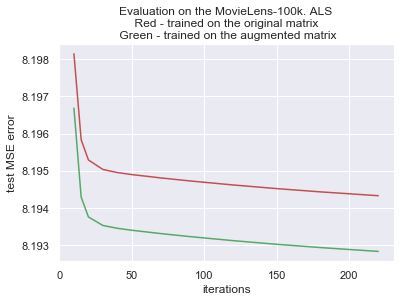

In [277]:
plt.plot(iter_array[3:], mf_als_100k.test_mse[3:], c='r')
plt.plot(iter_array[3:], mf_aug_als_100k.test_mse[3:], c='g')
plt.title('Evaluation on the MovieLens-100k. ALS\n Red - trained on the original matrix \n Green - trained on the augmented matrix')
plt.xlabel('iterations')
plt.ylabel('test MSE error')

In [278]:
print('Best Test MSE error original. ALS', min(mf_als_100k.test_mse))
print('Best Test MSE error augmented. ALS', min(mf_aug_als_100k.test_mse))

Best Test MSE error original. ALS 8.194329080408963
Best Test MSE error augmented. ALS 8.192832277122065


Text(0, 0.5, 'test MSE error')

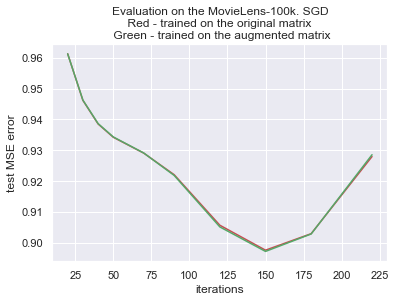

In [253]:
plt.plot(iter_array[5:], mf_sgd_100k.test_mse[5:], c='r')
plt.plot(iter_array[5:], mf_aug_sgd_100k.test_mse[5:], c='g')
plt.title('Evaluation on the MovieLens-100k. SGD\n Red - trained on the original matrix \n Green - trained on the augmented matrix')
plt.xlabel('iterations')
plt.ylabel('test MSE error')

In [260]:
print('Best Test MSE error original. SGD', min(mf_sgd_100k.test_mse))
print('Best Test MSE error augmented. SGD', min(mf_aug_sgd_100k.test_mse))

Best Test MSE error original. SGD 0.8975222763790961
Best Test MSE error augmented. SGD 0.8971202476946889


Text(0, 0.5, 'test MSE error')

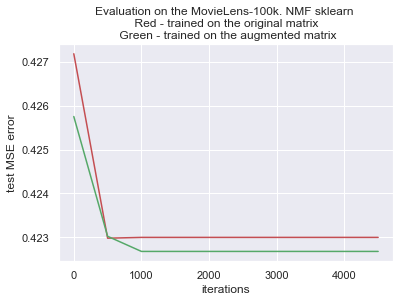

In [249]:
plt.plot(range(0, 5000, 500), mse_NMF, c='r')
plt.plot( range(0, 5000, 500), mse_augm_NMF, c='g')
plt.title('Evaluation on the MovieLens-100k. NMF sklearn \n Red - trained on the original matrix \n Green - trained on the augmented matrix')
plt.xlabel('iterations')
plt.ylabel('test MSE error')

In [262]:
print('Best Test MSE error original. Sklearn NMF', min(mse_NMF))
print('Best Test MSE error augmented. Sklearn NMF', min(mse_augm_NMF))

Best Test MSE error original. Sklearn NMF 0.42298122996749166
Best Test MSE error augmented. Sklearn NMF 0.4226800422407156


# The same evaluation process goes for the MovieLens-1m